In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import tensorflow.keras as keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
data_path = Path('./kaggle_input/')
training_path = data_path / 'training'      # 400 X-train ('train'), y-train('test') input-output pairs
evaluation_path = data_path / 'evaluation'  # 400
test_path = data_path / 'test'              # 100 pairs X-train ('train') (input-output),
                                            #           y-train (input only) pairs

training_tasks_files = sorted(os.listdir(training_path))#[1:]
eval_tasks_files = sorted(os.listdir(evaluation_path))
test_task_files = sorted(os.listdir(test_path))

In [3]:
def load_files(path):
    path_files = sorted(os.listdir(path))
    tasks = []
    for task_file in path_files:
        with open(str(path / task_file), 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [4]:
training_tasks = load_files(training_path)
test_tasks = load_files(test_path)
evaluation_tasks = load_files(evaluation_path)

In [5]:
training_tasks[0]#['test'][0]

{'test': [{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]],
   'output': [[7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 7, 0, 0, 0, 0, 7, 7, 0],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 7, 0, 0, 0, 0, 7, 7, 0],
    [7, 0, 7, 7, 0, 7, 0, 0, 0],
    [7, 0, 7, 7, 0, 7, 0, 0, 0],
    [7, 7, 0, 7, 7, 0, 0, 0, 0]]}],
 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]],
   'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 7, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 7, 7, 0, 7, 7, 0, 7, 7],
    [7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 7, 7, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 7, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7]]},
  {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]],
   'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4

 
 ---
 ---

### 1. Create Train - Test - Split

In [6]:
Xs_test, ys_test, Xs_train, ys_train = [], [], [], []

for task in training_tasks:
    X_test, y_test, X_train, y_train = [], [], [], []

    for pair in task["test"]:
        X_test.append(pair["input"])
        y_test.append(pair["output"])      ### to be predicted !!!

    for pair in task["train"]:
        X_train.append(pair["input"])
        y_train.append(pair["output"])
    
    Xs_test.append(X_test)
    ys_test.append(y_test)
    Xs_train.append(X_train)
    ys_train.append(y_train)

In [7]:
len(Xs_train), len(ys_train), len(Xs_test), len(ys_test)

(400, 400, 400, 400)

In [8]:
### put this in a fct later
# cv2.resize(np.asarray(train_data['input']), dsize=(32, 32), interpolation=cv2.INTER_NEAREST))

li=[]
for X_train in Xs_train:
    for e in X_train:
        e = np.array(e)
        e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
        li.append(e)
X_train_big = np.array(li)

In [9]:
X_train_big = X_train_big / 10.
#X_train_big = X_train_big.reshape(1301,32,32, 1)  #(x_train.shape + (1,) )

In [10]:
X_train_big.shape

(1301, 32, 32)

In [11]:
li=[]
for X_test in Xs_test:
    for e in X_test:
        e = np.array(e)
        e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
        li.append(e)
X_test_big = np.array(li)

In [12]:
X_test_big.shape

(416, 32, 32)

In [13]:
X_test_big = X_test_big / 10.
#X_test_big = X_test_big.reshape(416,32,32, 1)  #(x_train.shape + (1,) )

In [14]:
K.clear_session()

latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(1024, activation='sigmoid'),
            layers.Reshape((32, 32))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [15]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])

In [ ]:
autoencoder.fit(X_train_big, X_train_big,
                epochs=100,
                batch_size=5000,
                #shuffle=True,
                validation_data=(X_test_big, X_test_big))

In [ ]:
encoded_imgs = autoencoder.encoder(X_test_big).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_big[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## get the ys involved too???


In [16]:
li=[]
for y_train in ys_train:
    for e in y_train:
        e = np.array(e)
        e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
        li.append(e)
y_train_big = np.array(li)

In [17]:
y_train_big.shape

(1301, 32, 32)

In [18]:
y_train_big = y_train_big / 10.
#y_train_big = y_train_big.reshape(1301,32,32, 1)  #(x_train.shape + (1,) )

In [19]:
y_train_big.shape

(1301, 32, 32)

In [20]:
li=[]
for y_test in ys_test:
    for e in y_test:
        e = np.array(e)
        e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
        li.append(e)
y_test_big = np.array(li)

In [21]:
y_test_big.shape

(416, 32, 32)

In [22]:
y_test_big = y_test_big / 10.

In [23]:
#y_test_big = y_test_big.reshape(416,32,32, 1)  #(x_train.shape + (1,) )

In [24]:
y_test_big.shape

(416, 32, 32)

In [25]:
#X_train_big = X_train_big.reshape(1301,32,32, 1)
#X_test_big = X_test_big.reshape(416,32,32, 1) 

In [26]:
X_train_big.shape, X_test_big.shape

((1301, 32, 32), (416, 32, 32))

In [27]:
autoencoder.fit(X_train_big, y_train_big,
                epochs=100,
                batch_size=5000,
                #shuffle=True,
                validation_data=(X_test_big, y_test_big))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2416 - accuracy: 0.0375 - val_loss: 0.2380 - val_accuracy: 0.0286
Epoch 2/100
1/1 [==============================] - 0s 103ms/step - loss: 0.2409 - accuracy: 0.0308 - val_loss: 0.2371 - val_accuracy: 0.0297
Epoch 3/100
1/1 [==============================] - 0s 101ms/step - loss: 0.2402 - accuracy: 0.0311 - val_loss: 0.2362 - val_accuracy: 0.0297
Epoch 4/100
1/1 [==============================] - 0s 84ms/step - loss: 0.2393 - accuracy: 0.0323 - val_loss: 0.2350 - val_accuracy: 0.0304
Epoch 5/100
1/1 [==============================] - 0s 103ms/step - loss: 0.2382 - accuracy: 0.0333 - val_loss: 0.2336 - val_accuracy: 0.0299
Epoch 6/100
1/1 [==============================] - 0s 94ms/step - loss: 0.2370 - accuracy: 0.0337 - val_loss: 0.2319 - val_accuracy: 0.0303
Epoch 7/100
1/1 [==============================] - 0s 92ms/step - loss: 0.2355 - accuracy: 0.0350 - val_loss: 0.2299 - val_accuracy: 0.0316
Epoch 8/100
1/1 [==

1/1 [==============================] - 0s 78ms/step - loss: 0.0649 - accuracy: 0.0645 - val_loss: 0.0563 - val_accuracy: 0.0565
Epoch 60/100
1/1 [==============================] - 0s 81ms/step - loss: 0.0633 - accuracy: 0.0637 - val_loss: 0.0550 - val_accuracy: 0.0558
Epoch 61/100
1/1 [==============================] - 0s 85ms/step - loss: 0.0617 - accuracy: 0.0630 - val_loss: 0.0537 - val_accuracy: 0.0555
Epoch 62/100
1/1 [==============================] - 0s 90ms/step - loss: 0.0601 - accuracy: 0.0622 - val_loss: 0.0524 - val_accuracy: 0.0545
Epoch 63/100
1/1 [==============================] - 0s 86ms/step - loss: 0.0586 - accuracy: 0.0613 - val_loss: 0.0512 - val_accuracy: 0.0542
Epoch 64/100
1/1 [==============================] - 0s 96ms/step - loss: 0.0572 - accuracy: 0.0605 - val_loss: 0.0500 - val_accuracy: 0.0539
Epoch 65/100
1/1 [==============================] - 0s 86ms/step - loss: 0.0558 - accuracy: 0.0597 - val_loss: 0.0489 - val_accuracy: 0.0530
Epoch 66/100
1/1 [========

In [82]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
Total params: 65,600
Trainable params: 65,600
Non-trainable params: 0
_________________________________________________________________


In [83]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              66560     
_________________________________________________________________
reshape (Reshape)            (None, 32, 32)            0         
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________


In [28]:
w = X_train_big[125:126]#.shape

In [29]:
w.shape

(1, 32, 32)

In [30]:
v = w*10

In [31]:
pred = autoencoder.predict(w)#.reshape(1,30,30)

In [32]:
pred.shape

(1, 32, 32)

In [33]:
new_arr = np.around(pred,1)*10

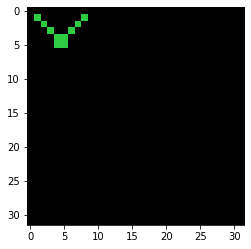

In [34]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
plt.imshow(v[0], cmap=cmap, norm=norm)

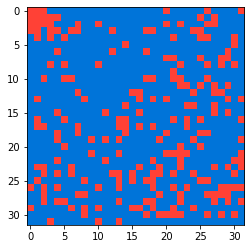

In [35]:
plt.imshow(new_arr[0], cmap=cmap, norm=norm)

In [57]:
x = X_train_big[125:126]
# print(x.shape)
# encoded_imgs = autoencoder.encoder(x.reshape((1,32,32) +(1,)))
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

pred_x = autoencoder.predict(x.reshape(1,32,32,1))
pred_x = pred_x.reshape(32,32)
pred_x = np.around(pred_x,1)*10

     

x = (x.reshape(32,32))*10

y = y_train_big[125]*10



test = X_test_big[40]*10

test = (test.reshape(32,32))#*10

encoded_imgs2 = autoencoder.encoder((X_test_big[125:126]).reshape(X_test_big[125:126].shape +(1,))).numpy()
decoded_imgs2 = autoencoder.decoder(encoded_imgs2).numpy()

pred_t = (decoded_imgs2.reshape(32,32))*100
pred_t = np.around(pred_t,1)*10

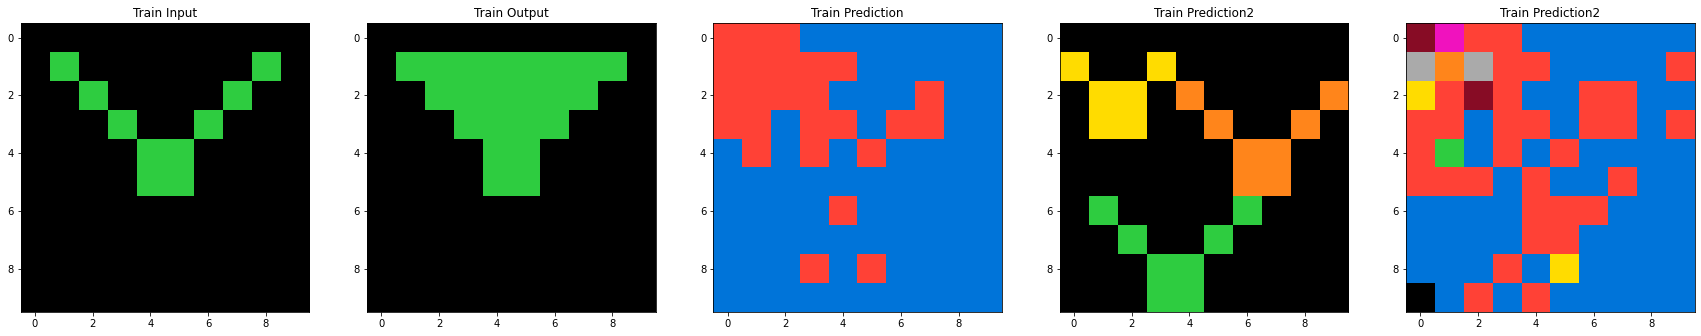

In [63]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 5, figsize=(30,30))
ax[0].imshow(x[:10,:10], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(y[:10,:10], cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(pred_x[:10,:10], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction')
ax[3].imshow(test[:10,:10], cmap=cmap, norm=norm)
ax[3].set_title('Train Prediction2')
ax[4].imshow(pred_t[:10,:10], cmap=cmap, norm=norm)
ax[4].set_title('Train Prediction2');

## ---------------------------------------

In [ ]:
K.clear_session()

latent_dim = 64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', padding='same',input_shape = (32,32,1)), 
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same')#,
#             layers.Flatten(),
#             layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = Sequential([
#             layers.Dense(64, activation='sigmoid'),
#             layers.Reshape((32, 32,1)),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(1, (3, 3), activation='softmax', padding='same')

        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])

In [ ]:
autoencoder.fit(X_train_big, y_train_big,
                epochs=100,
                batch_size=5000,
                #shuffle=True,
                validation_data=(X_test_big, y_test_big))

In [ ]:
autoencoder.summary()

In [ ]:
encoded_imgs = autoencoder.encoder(X_test_big).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_big[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
decoded_imgs = autoencoder.predict(X_test_big)

n = 10
plt.figure(figsize=(20, 4))


cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    orig_shape = np.asarray(Xs_test[i]).shape[1:]
    plt.imshow(X_test_big[i][:orig_shape[0],:orig_shape[1]]*10, cmap=cmap, norm=norm)#.reshape(orig_shape[0],orig_shape[1]) ## Xs_test
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(X_test_big)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()